In [1]:
import copy
import torch
import numpy as np
from tqdm.auto import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt

import seaborn as sn
from alexnet import AlexNet
from utils import evaluate,cifar10_loader


In [2]:
alexnet = AlexNet()
alexnet.load_state_dict(torch.load("./alexnet_pretrained"))
alexnet.cuda()
trainloader,testloader = cifar10_loader(256,"../data")
print(evaluate(alexnet,trainloader,True))

0.96846


/home/aghinsa/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


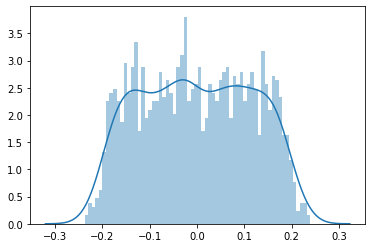

In [3]:
w = alexnet.conv1.weight.data.cpu()
sn.distplot(w.reshape(-1,1),bins=64,norm_hist=True)
plt.show()

In [4]:
class LayerData:
    def __init__(self):
        self.fs = None
        self.w = None
        self.n_out = None
        self.hashed_weight = None

In [16]:
class BitQuantizer:

    def __init__(self,n_fs,n_bits,layer_names,):
        self.n_fs = n_fs
        self.n_bits = n_bits
        self.layer_names = layer_names
        for layer_name in layer_names:
            setattr(self,layer_name,LayerData())
        self.all_encodings = self.get_binary_encodings(self.n_bits)
        self.all_encodings = torch.from_numpy(self.all_encodings).float().cuda()
            
    def _init_hashed_coefs(self,w,n):
        hist,bin_edges = np.histogram(w,bins=64,density = True)    
        vals = list(zip(hist,bin_edges[1:]))
        vals.sort(key = lambda x:x[0],reverse=True)
        vals = [ x[1] for x in vals[:6]  ]
        return np.array(vals).reshape(-1,1)
    
    def init_hash_functions(self,model):
        for layer in self.layer_names:
            w = getattr(model,layer).weight.data
            coefs = self._init_hashed_coefs(w.cpu(),self.n_bits)
            getattr(self,layer).fs = torch.from_numpy(np.repeat(coefs.reshape(1,-1),self.n_fs,axis=0)).cuda()
            getattr(self,layer).w = w
            getattr(self,layer).n_out = w.size()[0]
            
    
    def get_binary_encodings(self,n):
        """
        Generates all permutations of 1,-1 of given length n
        """
        ans = []
        low = (1<<n)
        high = (low << 1)

        for tx in range(low,high):
            tans = [-1]*n
            for j in range(n):
                if tx & (1<<j) :
                    tans[j]=1
            ans.append(tans)
        return np.array(ans)

    def train_hash_functions_for_layer(self,layer_name,n_iter = 100):
        layer_data = getattr(self,layer_name)
        w_master = layer_data.w
        
        with torch.no_grad():
            with torch.cuda.device("gpu"):
                for _ in tqdm(range(n_iter)):
                    channel_step = layer_data.n_out//self.n_fs

                    new_fs = []
                    new_ws = []

                    for fidx in range(0,self.n_fs):
                        # select hash functions for the channel batch
                        f = layer_data.fs[fidx].reshape(-1,1) #[nb,1]

                        if fidx != self.n_fs-1:
                            wx = w_master[fidx*channel_step:(fidx+1)*channel_step,:,:,: ] # [channel_step,inc,k,k]
                        else:
                            wx = w_master[fidx*channel_step:,:,:,: ] # [channel_step,inc,k,k]

                        # finding encoding for qhich quant level is closest to w
                        w = wx.reshape(-1,1)
                        quant_levels = torch.matmul(self.all_encodings, f) # [2^nb,1]

                        w = torch.abs( w - quant_levels.t()) # [m,2^nb]

                        idx = torch.argmin(w,dim = -1)

                        selected_encoding = self.all_encodings[idx] #[m,nbins]

                        # From the selected encodings generate hash values
                        new_w = torch.matmul(selected_encoding,f).reshape(wx.size())
                        new_ws.append(new_w)

                        # optimizing coefficients which minimizes square loss with
                        # current unhashed weights

                        # self.sgd.fit(selected_encoding.cpu(),wx.reshape(-1).cpu())
                        # f_new_bin = self.sgd.coef_
                        # f_new_bin = torch.from_numpy(f_new_bin).reshape(1,-1).float().cuda()
                        # new_fs.append(f_new_bin)

                        s = selected_encoding #[m,nb]
                        psued_inv = torch.pinverse(s)
                        f_new_bin = torch.matmul(psued_inv,wx.reshape(-1,1)) #[nb,1]
                        new_fs.append(f_new_bin.t())

                    new_fs = torch.cat(new_fs,axis=0)
                    alpha = 0.1
                    layer_data.fs = layer_data.fs + alpha * (new_fs - layer_data.fs)


            hashed_weight = torch.cat(new_ws,axis=0)
            layer_data.hashed_weight = hashed_weight
            
        setattr(self,layer_name,layer_data)
        return
    
    def train_hash_functions(self,layer_names= None,n_iter = 100):
        if layer_names is None:
            layer_names = self.layer_names
        for layer_name in self.layer_names:
            print(f"hashing layer: {layer_name}")
            self.train_hash_functions_for_layer(layer_name,n_iter)
    
    def hash_model_layers(self,input_model,layer_names = None):
        model = copy.deepcopy(input_model)
        
        if layer_names is None:
            layer_names = self.layer_names
        for layer_name in layer_names:
            getattr(model,layer_name).weight = nn.Parameter(
                getattr(self,layer_name).hashed_weight)
        return model

            
        

In [17]:
n_fs = 16
n_bits = 6
layer_names = ["conv1","conv2","conv3","conv4","conv5","fc1","fc2"]
b = BitQuantizer(n_fs,n_bits,layer_names)
b.init_hash_functions(alexnet)

AttributeError: 'AlexNet' object has no attribute 'fc1'

In [7]:
b.train_hash_functions(n_iter = 1000)
hashed_model = b.hash_model_layers(input_model = alexnet)
hashed_model = hashed_model.cuda()
evaluate(hashed_model,trainloader,cuda=True)

hashing layer: conv1



hashing layer: conv2



hashing layer: conv3



hashing layer: conv4



hashing layer: conv5


0.96574